This notebook includes the code for training a Spyketorch-built, spiking convolutional neural network(SNN) without the labels of the images(cow,dog or horse from ETH80 dataset).

In [ ]:
!pip install git+https://github.com/miladmozafari/SpykeTorch.git

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
import numpy as np
from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

#importing all ETH animal images

#0: cow
#1: dog
#2: horse


Below samples from each class are shown

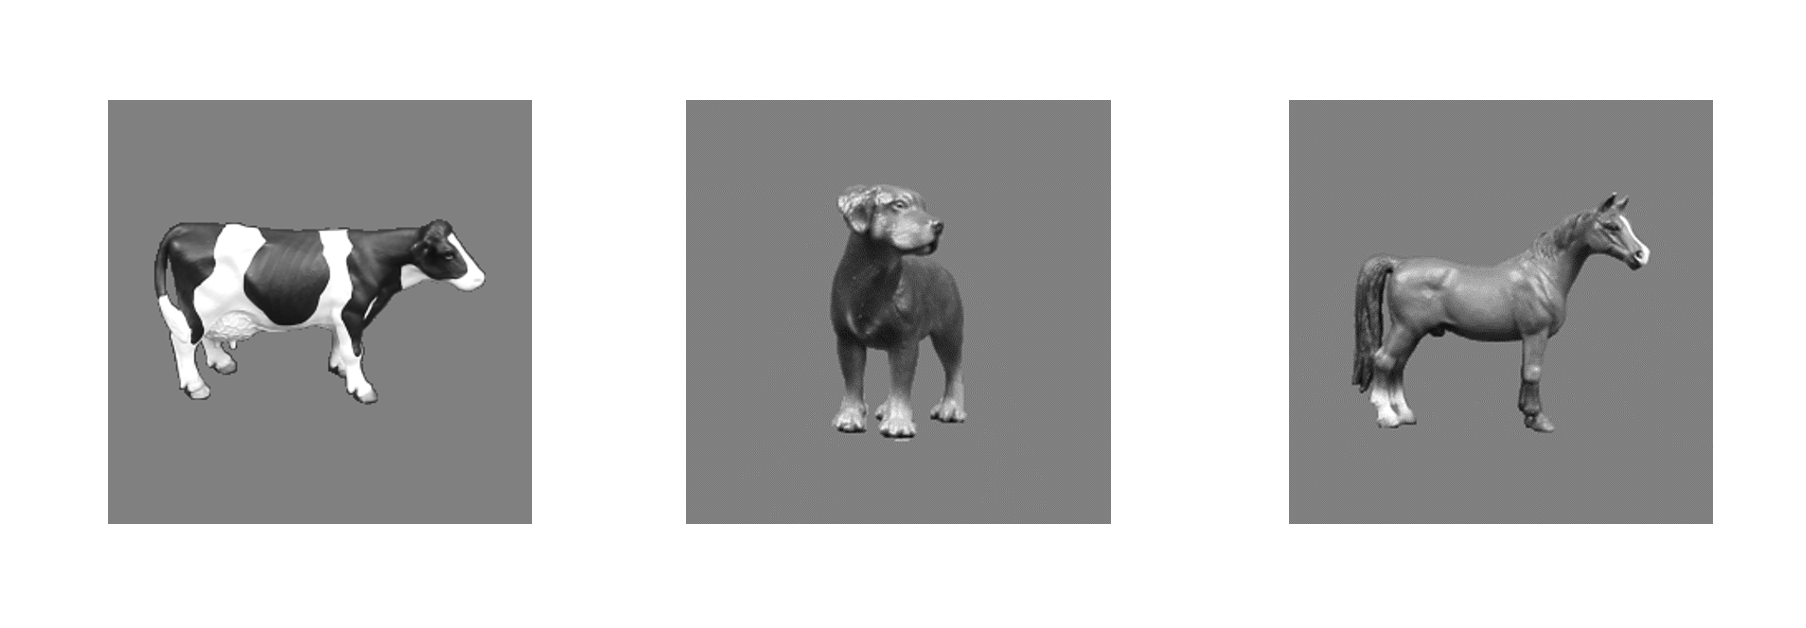

In [1]:
from IPython.display import Image
Image(filename="eth_animal_sample.png")

Spyketorch Model definition and importing the training image dataset(ETH80_animal)

In [ ]:

import os
from PIL import Image
# Path to the folder containing images

# List to store the loaded images
dict_folder={0:"training_images/cow", 1:"training_images/dog",
              2:"training_images/horse"}


image_list = []

# # Loop through all files in the folder

for key in dict_folder.keys():
    for filename in os.listdir(dict_folder[key]):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(dict_folder[key], filename)
            img = Image.open(img_path)
            img=img.convert("L")
            image_list.append((img,key))


class S1Transform:
    def __init__(self, filter, timesteps = 15):
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
    def __call__(self, image):
        
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

kernels = [ utils.DoGKernel(7,1,2),
            utils.DoGKernel(7,2,1),]
filter = utils.Filter(kernels, padding = 0, thresholds = 50)
s1 = S1Transform(filter)      


data_tensor=[]
data_label=[]

for (img,label) in image_list:

    data_tensor.append(s1(img))
    data_label.append(torch.tensor(label))


#################################################
data=TensorDataset(torch.stack(data_tensor),torch.stack(data_label))

use_cuda=False
train_data=[data[i][0] for i in range(len(data))]

######################################################
class Kheradpisheh_SNN(nn.Module):
    def __init__(self):
        super(Kheradpisheh_SNN, self).__init__()

        self.conv1 = snn.Convolution(2, 32, 5, 0.8, 0.05)
        self.conv1_t = 6
        self.k1 = 10
        self.r1 = 2

        self.conv2 = snn.Convolution(32, 150, 5, 0.8, 0.05)
        self.conv2_t = 2
        self.k2 = 100
        self.r2 = 1

        self.conv3 = snn.Convolution(150, 60, 5, 0.8, 0.05)
        self.conv3_t = 1
        self.k3 = 60
        self.r3 = 1
        
        self.stdp1 = snn.STDP(self.conv1, (0.008, -0.001))
        self.stdp2 = snn.STDP(self.conv2, (0.03, -0.001))
        self.stdp3 = snn.STDP(self.conv3, (0.03, -0.001))
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0
        self.spk_cnt3 = 0
    
    def save_data(self, input_spike, potentials, output_spikes, winners):
        self.ctx["input_spikes"] = input_spike
        self.ctx["potentials"] = potentials
        self.ctx["output_spikes"] = output_spikes
        self.ctx["winners"] = winners

    def forward(self, input, max_layer=None):
        input = sf.pad(input.float(), (2,2,2,2), 0)
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.save_data(input, pot, spk, winners)
                return spk, pot
            spk_in = sf.pad(sf.pooling(spk, 3, 3, 1), (1,1,1,1))
            spk_in = sf.pointwise_inhibition(spk_in)
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.save_data(spk_in, pot, spk, winners)
                return spk, pot

            spk_in = sf.pad(sf.pooling(spk, 3, 3, 1), (1,1,1,1))
            spk_in = sf.pointwise_inhibition(spk_in)
            pot = self.conv3(spk_in)
            spk, pot = sf.fire(pot, self.conv3_t, True)    
            if max_layer == 3:
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k3, self.r3, spk)
                self.save_data(spk_in, pot, spk, winners)
                return spk, pot    
            
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            pot = sf.pointwise_inhibition(pot)
            spk = pot.sign()
            spk_1=sf.pooling(spk, 3, 3, 1)
            pot = self.conv2(sf.pad(spk_1, (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            pot = sf.pointwise_inhibition(pot)
            spk = pot.sign()
            spk_2 = sf.pooling(spk, 3, 3, 1)
            pot = self.conv3(sf.pad(spk_2, (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv3_t, True)
            pot = sf.pointwise_inhibition(pot)
            spk = pot.sign()
            spk_3 = sf.pooling(spk, 3, 3, 1)
            return spk_3,spk_2,spk_1
    
    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 3:
            self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])    
            
    ##################################################
    
def train_unsupervise(network, data, layer_idx):
    network.train()
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def test(network, data, target, layer_idx):
    network.eval()
    ans = [None] * len(data)
    t = [None] * len(data)
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        output,_ = network(data_in, layer_idx).max(dim = 0)
        ans[i] = output.reshape(-1).cpu().numpy()
        t[i] = target[i]
    return np.array(ans), np.array(t)    

Training phase, with a STDP unsupervised manner requiring GPU acceleration. It takes about 40 minutes to train the weights of all convolutional kernels.
Notice the epoch numbers of each conv layer.

In [ ]:
use_cuda=True

linear_filter_snn_model = Kheradpisheh_SNN()

if use_cuda:
    linear_filter_snn_model.cuda()
   
n_epoch_1=20
n_epoch_2=40
n_epoch_3=80


#Training The First Layer

print("Training the first layer")

for epoch in range(n_epoch_1):
    print("Epoch", epoch+1)
        
    if epoch%20==0:
        torch.save(linear_filter_snn_model.state_dict(), f"saved_l1_kheradpisheh_{epoch}.net")
       
    train_unsupervise(linear_filter_snn_model, train_data, 1)
    
            
torch.save(linear_filter_snn_model.state_dict(), "saved_l1_kheradpisheh.net")

# Training The second Layer
print("Training the second layer")

for epoch in range(n_epoch_2):
    print("Epoch", epoch+1)
    
    if epoch%20==0:
        torch.save(linear_filter_snn_model.state_dict(), f"saved_l2_kheradpisheh_{epoch}.net")
        
    train_unsupervise(linear_filter_snn_model, train_data, 2)
    
    
torch.save(linear_filter_snn_model.state_dict(), "saved_l2_kheradpisheh.net")

#Training The third Layer
print("Training the third layer")

for epoch in range(n_epoch_3):
    print("Epoch", epoch+1)
    
    if epoch%20==0:
        torch.save(linear_filter_snn_model.state_dict(), f"saved_l3_kheradpisheh_{epoch}.net")    
    
    train_unsupervise(linear_filter_snn_model, train_data, 3)

    #if the convergence index of the last convolutional layer is lower than 0.01 then the training is terminated
    w3_array=linear_filter_snn_model.conv3._parameters["weight"].cpu().numpy()
    if np.mean(w3_array.reshape(-1)*(1-w3_array.reshape(-1)))<0.01:
        print("Layer 3 is done (C<0.01)")
        break
    
torch.save(linear_filter_snn_model.state_dict(), "saved_l3_kheradpisheh_final.net")

Now let's check the weight histograms before and after the training, along with the shape of first layer's learned kernels.

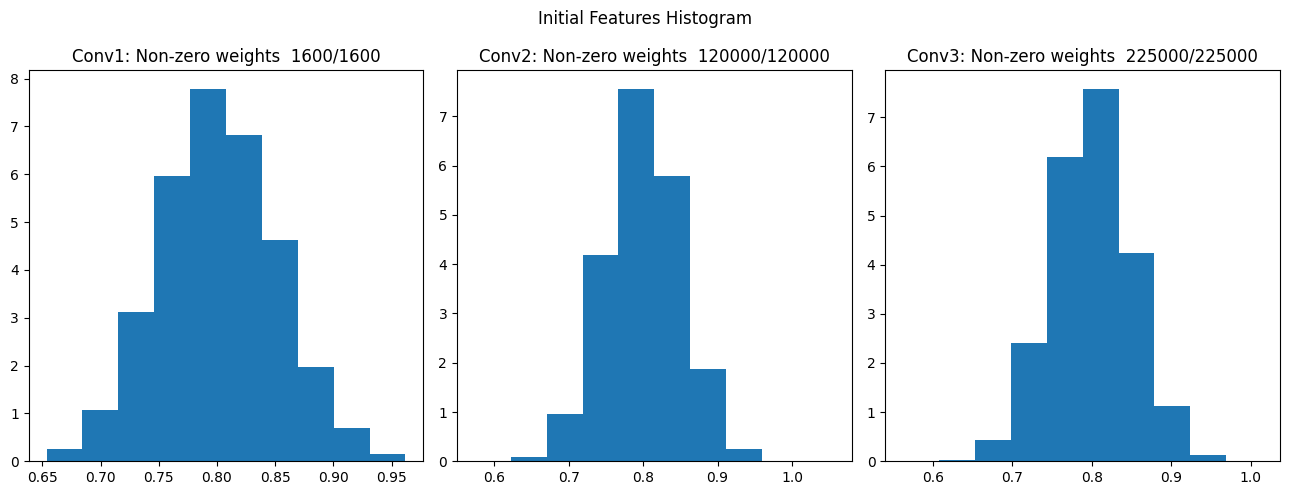

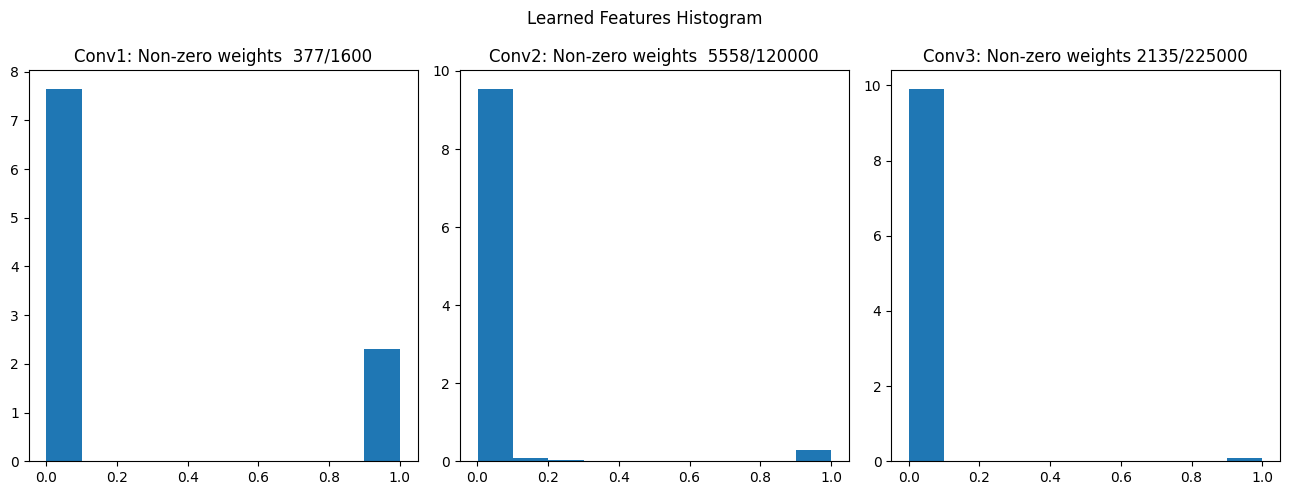

last layer's Convergence index= 0.0001


In [5]:
#convergence index definition, if this measure falls below 0.01 we confirm that the training has been successfully done; this is the convergence criterion. 
def convergence_index(conv_weights):
    return np.mean(conv_weights.reshape(-1)*(1-conv_weights.reshape(-1)))

#for model evaluation no need for GPU accelaration
use_cuda=False

linear_filter_snn_model = Kheradpisheh_SNN()

if use_cuda:
    linear_filter_snn_model.cuda()

linear_filter_snn_model.eval()

w1_array_initial=linear_filter_snn_model.conv1._parameters["weight"].cpu().numpy()
w2_array_initial=linear_filter_snn_model.conv2._parameters["weight"].cpu().numpy()
w3_array_initial=linear_filter_snn_model.conv3._parameters["weight"].cpu().numpy()

plt.figure(figsize=(13,5))
plt.suptitle("Initial Features Histogram",fontsize=12)
plt.subplot(1,3,1)
plt.hist(w1_array_initial.reshape(-1),density=True)
plt.title(f"Conv1: Non-zero weights  {len(w1_array_initial.reshape(-1)[w1_array_initial.reshape(-1)>0.1])}/{len(w1_array_initial.reshape(-1))}")

plt.subplot(1,3,2)
plt.hist(w2_array_initial.reshape(-1),density=True)
plt.title(f"Conv2: Non-zero weights  {len(w2_array_initial.reshape(-1)[w2_array_initial.reshape(-1)>0.1])}/{len(w2_array_initial.reshape(-1))}")

plt.subplot(1,3,3)
plt.hist(w3_array_initial.reshape(-1),density=True)
plt.title(f"Conv3: Non-zero weights  {len(w3_array_initial.reshape(-1)[w3_array_initial.reshape(-1)>0.1])}/{len(w3_array_initial.reshape(-1))}")


#plt.savefig("hist_learned_weights")
plt.tight_layout()
plt.show()


#importing the already saved model on CPU
linear_filter_snn_model.load_state_dict(torch.load("saved_l3_kheradpisheh_final.net",
                                                map_location=torch.device('cpu')))

w1_array=linear_filter_snn_model.conv1._parameters["weight"].cpu().numpy()
w2_array=linear_filter_snn_model.conv2._parameters["weight"].cpu().numpy()
w3_array=linear_filter_snn_model.conv3._parameters["weight"].cpu().numpy()


plt.figure(figsize=(13,5))
plt.suptitle("Learned Features Histogram",fontsize=12)
plt.subplot(1,3,1)
plt.hist(w1_array.reshape(-1),density=True)
plt.title(f"Conv1: Non-zero weights  {len(w1_array.reshape(-1)[w1_array.reshape(-1)>0.1])}/{len(w1_array.reshape(-1))}")

plt.subplot(1,3,2)
plt.hist(w2_array.reshape(-1),density=True)
plt.title(f"Conv2: Non-zero weights  {len(w2_array.reshape(-1)[w2_array.reshape(-1)>0.1])}/{len(w2_array.reshape(-1))}")

plt.subplot(1,3,3)
plt.hist(w3_array.reshape(-1),density=True)
plt.title(f"Conv3: Non-zero weights {len(w3_array.reshape(-1)[w3_array.reshape(-1)>0.1])}/{len(w3_array.reshape(-1))}")


#plt.savefig("hist_learned_weights")
plt.tight_layout()
plt.show()

print(f"last layer's Convergence index= {convergence_index(w3_array):.4f}")

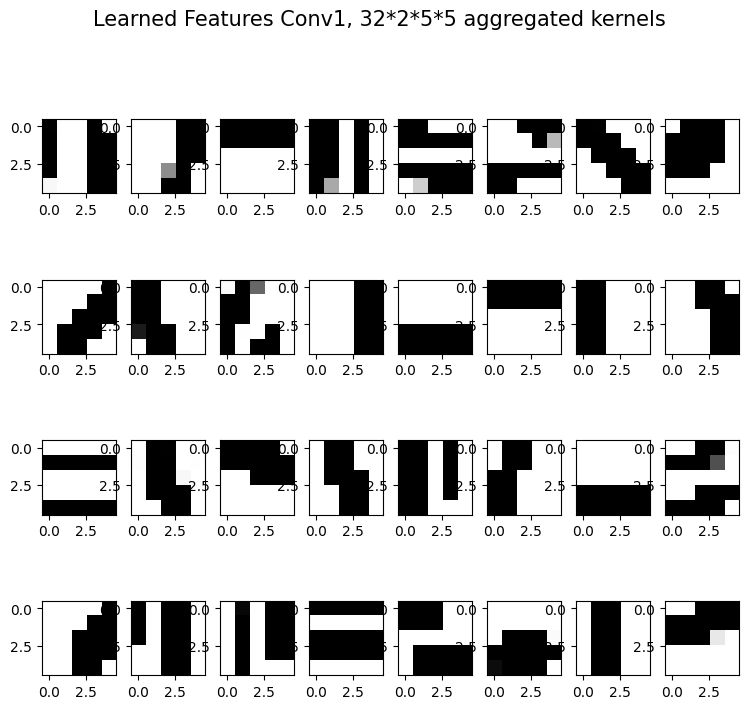

In [10]:
plt.figure(figsize=(9,8))
plt.suptitle("Learned Features Conv1, 32*2*5*5 aggregated kernels",fontsize=15)
for i in range(w1_array.shape[0]):
    plt.subplot(4,8,i+1)
    plt.imshow(w1_array[i].sum(axis=0),cmap="binary")

#plt.tight_layout()
#plt.savefig("l1_kernels")
plt.show()

Figure above shows why I'd chosen those specific number of epochs, indeed the selected ones are sufficient for having a well trained Spyketorch model

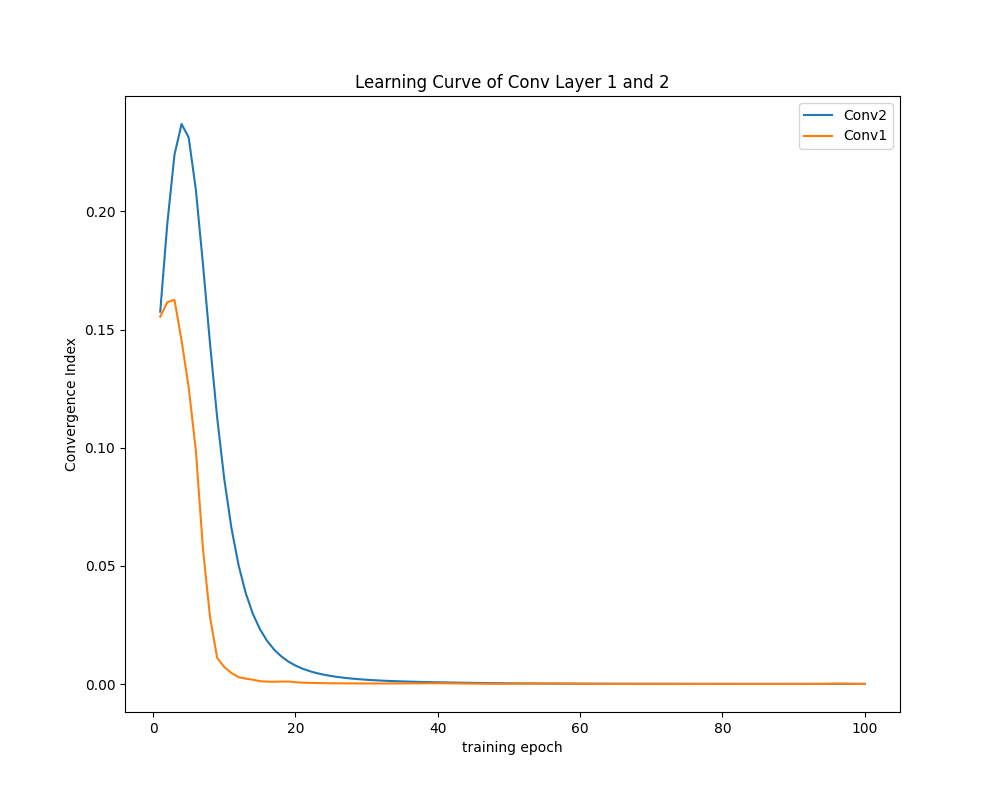

In [11]:
from IPython.display import Image
Image(filename="layer1_vs_2.png")